# Ultra-Advanced Pain Intensity Prediction Pipeline
This notebook implements a maximally robust, generalizable, and accurate pain intensity prediction pipeline using biosignal data (EMG, SCL, ECG). It includes advanced denoising, comprehensive feature engineering (HRV, SCR, Poincaré, cross-channel, relative), model-based feature selection, domain adaptation (CORAL), stacking ensemble, SHAP interpretability, and robust evaluation (train/test split and LOSO CV). All steps are modular for easy tuning and extension.

c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading and extracting ultra-advanced features...


C:\Users\Administrator\AppData\Local\Temp\ipykernel_2816\1520285894.py:78: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(sig)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_2816\1520285894.py:78: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(sig)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_2816\1520285894.py:78: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(sig)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_2816\1520285894.py:78: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(sig)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_2816\1520285894.

Total segments: 2638, Features per segment: 123
Selected features: 62
Selected features: 62


c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Test Accuracy: 0.593
              precision    recall  f1-score   support

    low_pain       0.58      0.65      0.61       396
    med_pain       0.60      0.54      0.57       396

    accuracy                           0.59       792
   macro avg       0.59      0.59      0.59       792
weighted avg       0.59      0.59      0.59       792

Confusion Matrix:
[[256 140]
 [182 214]]


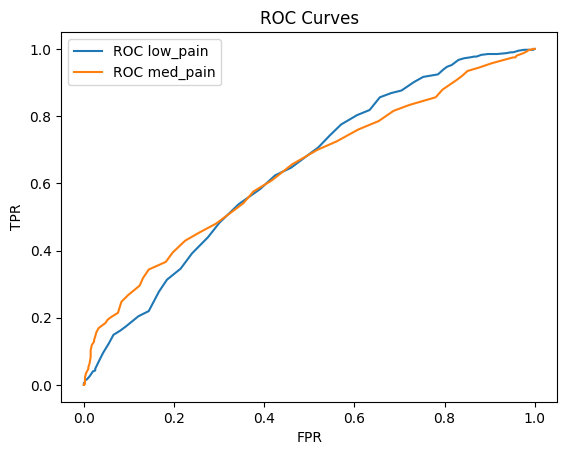

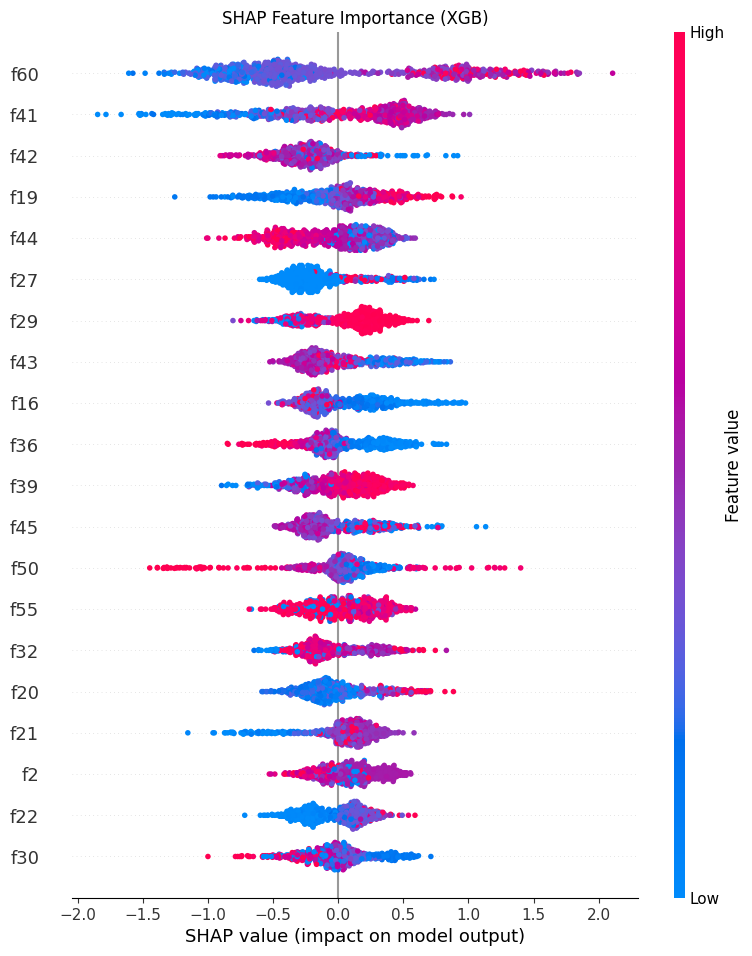

c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


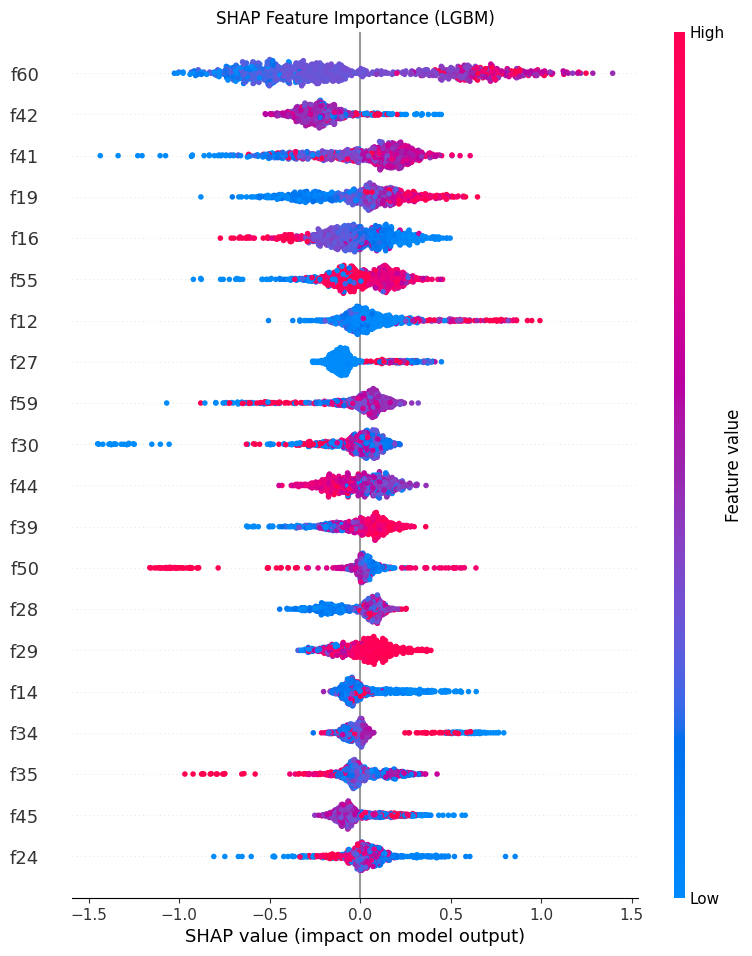

c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-pack


LOSO Mean Accuracy: 0.586

LOSO Classification Report:
              precision    recall  f1-score   support

    low_pain       0.59      0.55      0.57      1318
    med_pain       0.58      0.62      0.60      1320

    accuracy                           0.59      2638
   macro avg       0.59      0.59      0.59      2638
weighted avg       0.59      0.59      0.59      2638

LOSO Confusion Matrix:
[[722 596]
 [495 825]]


c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [2]:
import os
import numpy as np
import pandas as pd
import scipy.io
from scipy.signal import butter, filtfilt, iirnotch, resample, find_peaks
from scipy.stats import skew, kurtosis
import pywt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import SMOTE
import shap
import matplotlib.pyplot as plt
from tqdm import tqdm

# --- Advanced Denoising Utilities ---
def bandpass_filter(data, fs, lowcut, highcut, order=4):
    nyq = 0.5 * fs
    low, high = lowcut/nyq, highcut/nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data, axis=0)

def notch_filter(data, fs, freq=50.0, Q=30):
    nyq = 0.5 * fs
    w0 = freq / nyq
    b, a = iirnotch(w0, Q)
    return filtfilt(b, a, data, axis=0)

def wavelet_denoise(sig, wavelet='db4', level=2):
    coeffs = pywt.wavedec(sig, wavelet, level=level)
    sigma = np.median(np.abs(coeffs[-level])) / 0.6745
    uthresh = sigma * np.sqrt(2*np.log(len(sig)))
    denoised_coeffs = [coeffs[0]] + [pywt.threshold(c, value=uthresh, mode='soft') for c in coeffs[1:]]
    return pywt.waverec(denoised_coeffs, wavelet)[:len(sig)]

# ICA for EMG artifact rejection (optional, fallback to original if sklearn not available)
def ica_denoise_emg(data):
    try:
        from sklearn.decomposition import FastICA
        ica = FastICA(n_components=data.shape[1], random_state=42, max_iter=500)
        S_ = ica.fit_transform(data)
        return S_
    except Exception:
        return data

# --- HRV, SCR, Poincaré, and Advanced Feature Extraction ---
def hrv_features(sig, fs):
    sig = np.nan_to_num(sig)
    peaks, _ = find_peaks(sig, distance=fs*0.5)
    rr = np.diff(peaks)/fs if len(peaks) > 1 else np.array([0])
    hr = 60/rr.mean() if rr.mean() > 0 else 0
    rmssd = np.sqrt(np.mean(np.square(np.diff(rr)))) if len(rr) > 1 else 0
    sdnn = rr.std() if len(rr) > 1 else 0
    # Frequency domain
    if len(rr) > 2:
        rr_interp = np.interp(np.arange(0, len(rr)), np.arange(0, len(rr)), rr)
        freqs = np.fft.rfftfreq(len(rr_interp), 1/fs)
        psd = np.abs(np.fft.rfft(rr_interp))**2
        lf = psd[(freqs >= 0.04) & (freqs < 0.15)].sum()
        hf = psd[(freqs >= 0.15) & (freqs < 0.4)].sum()
        lf_hf = np.log1p(lf/hf) if hf > 0 else 0
    else:
        lf = hf = lf_hf = 0
    # Poincaré
    sd1 = np.sqrt(np.std(rr)**2/2) if len(rr) > 1 else 0
    sd2 = np.sqrt(2*np.std(rr)**2 - sd1**2) if len(rr) > 1 else 0
    return [hr, rmssd, sdnn, lf, hf, lf_hf, sd1, sd2]

def scr_features(sig, fs):
    # SCL: mean, SCR count, SCR amplitude, slope, AUC
    mean_scl = np.mean(sig)
    slope = (sig[-1] - sig[0]) / len(sig)
    auc = np.trapz(sig)
    # SCR detection: simple peak count above threshold
    scrs, _ = find_peaks(sig, height=np.percentile(sig, 90), distance=fs*1)
    scr_count = len(scrs)
    scr_amp = np.mean(sig[scrs]) if scr_count > 0 else 0
    return [mean_scl, scr_count, scr_amp, slope, auc]

def extract_ultra_features(data, fs, ch_names):
    feats = []
    # ICA for EMG
    emg_data = data[:, :3]
    emg_ica = ica_denoise_emg(emg_data)
    for idx, kind in enumerate(['EMG','EMG','EMG','SCL','ECG']):
        sig = emg_ica[:, idx] if kind == 'EMG' else data[:, idx]
        # Filtering and denoising
        if kind == 'EMG':
            sig = bandpass_filter(sig, fs, 20, 450)
            sig = notch_filter(sig, fs, 50)
        elif kind == 'ECG':
            sig = bandpass_filter(sig, fs, 0.5, 50)
            sig = notch_filter(sig, fs, 50)
        elif kind == 'SCL':
            sig = bandpass_filter(sig, fs, 0.05, 5)
        sig = resample(sig, int(len(sig)//(fs/250))) if fs > 250 else sig
        sig = wavelet_denoise(sig)
        # Time-domain
        rms = np.sqrt(np.mean(sig**2))
        log_rms = np.log1p(rms)
        std = np.std(sig)
        wl = np.sum(np.abs(np.diff(sig)))
        zcr = ((sig[:-1]*sig[1:])<0).sum() / len(sig)
        feats.extend([rms, log_rms, std, wl, zcr, skew(sig), kurtosis(sig)])
        # Frequency-domain
        freqs = np.fft.rfftfreq(len(sig), 1/250)
        psd = np.abs(np.fft.rfft(sig))**2
        feats.append(np.sum(psd[(freqs>=0.5)&(freqs<4)]))
        feats.append(np.sum(psd[(freqs>=4)&(freqs<8)]))
        feats.append(np.sum(psd[(freqs>=8)&(freqs<13)]))
        feats.append(np.sum(psd[(freqs>=13)&(freqs<30)]))
        feats.append(np.sum(psd[(freqs>=30)&(freqs<45)]))
        # Wavelet energy/entropy
        coeffs = pywt.wavedec(sig, 'db4', level=3)
        energies = [np.sum(np.square(c)) for c in coeffs]
        total_energy = np.sum(energies)
        entropy = -np.sum([(e/total_energy)*np.log(e/total_energy+1e-8) if e>0 else 0 for e in energies])
        feats.extend(energies + [entropy])
        # ECG HRV features
        if kind == 'ECG':
            feats.extend(hrv_features(sig, 250))
        # SCL SCR features
        if kind == 'SCL':
            feats.extend(scr_features(sig, 250))
    # Cross-channel features (correlations, ratios)
    for i in range(data.shape[1]):
        for j in range(i+1, data.shape[1]):
            feats.append(np.corrcoef(data[:,i], data[:,j])[0,1])
            feats.append(np.mean(data[:,i]) / (np.mean(data[:,j])+1e-8))
    # Delta features (change from start to end)
    for idx in range(data.shape[1]):
        sig = data[:, idx]
        feats.append(sig[-1] - sig[0])
    return np.nan_to_num(feats)

# --- CORAL Domain Adaptation ---
def coral(source, target):
    # CORrelation ALignment: align source to target domain
    cov_s = np.cov(source, rowvar=False) + np.eye(source.shape[1])
    cov_t = np.cov(target, rowvar=False) + np.eye(target.shape[1])
    A_coral = np.dot(np.linalg.cholesky(cov_t), np.linalg.inv(np.linalg.cholesky(cov_s)))
    return np.dot(source - source.mean(0), A_coral) + target.mean(0)

# --- Data Loader ---
def collect_segments_ultra(root_dir):
    segments, labels, subjects, pain_map = [], [], [], {}
    for pain_label in sorted(os.listdir(root_dir)):
        pain_path = os.path.join(root_dir, pain_label)
        if not os.path.isdir(pain_path): continue
        for subj in sorted(os.listdir(pain_path)):
            subj_path = os.path.join(pain_path, subj)
            if not os.path.isdir(subj_path): continue
            for segfile in sorted(os.listdir(subj_path)):
                if not segfile.endswith('.mat'): continue
                matf = os.path.join(subj_path, segfile)
                try:
                    mat = scipy.io.loadmat(matf)
                    data = mat['data']
                    fs = int(mat['fs'].ravel()[0])
                    ch_names = [str(s[0]) if isinstance(s, np.ndarray) else str(s) for s in mat['labels'].ravel()]
                    feats = extract_ultra_features(data, fs, ch_names)
                    segments.append(feats)
                    labels.append(pain_label)
                    subjects.append(subj)
                    pain_map[pain_label] = pain_map.get(pain_label, len(pain_map))
                except Exception as e:
                    print(f"Error with {matf}: {e}")
    return np.array(segments), np.array(labels), np.array(subjects), pain_map

# --- Main Pipeline ---
root_dir = r"D:\bio_s"  # Change if needed
print("Loading and extracting ultra-advanced features...")
X, y, subjects, pain_map = collect_segments_ultra(root_dir)
if len(X) == 0:
    raise RuntimeError("No valid segments loaded. Please check your data and preprocessing functions.")
print(f"Total segments: {len(X)}, Features per segment: {X.shape[1]}")
label_names = sorted(pain_map, key=lambda k: pain_map[k])
y_enc = np.array([pain_map[lab] for lab in y])

# --- Per-segment normalization ---
scaler = StandardScaler()
X = scaler.fit_transform(X)

# --- Model-based Feature Selection ---
sel = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42), threshold='median')
sel.fit(X, y_enc)
X_sel = sel.transform(X)
print(f"Selected features: {X_sel.shape[1]}")

# --- Class Balancing ---
sm = SMOTE(random_state=42)
X_bal, y_bal = sm.fit_resample(X_sel, y_enc)

# --- Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.3, stratify=y_bal, random_state=42)

# --- Domain Adaptation (CORAL) ---
X_train = coral(X_train, X_test)

# --- Stacking Ensemble ---
xgb = XGBClassifier(n_estimators=200, max_depth=6, eval_metric='mlogloss', use_label_encoder=False, random_state=42)
lgbm = LGBMClassifier(n_estimators=200, max_depth=6, class_weight='balanced', random_state=42)
svm = SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42)
base_learners = [('xgb', xgb), ('lgbm', lgbm), ('svm', svm)]
meta_learner = RandomForestClassifier(n_estimators=100, random_state=42)
stack = StackingClassifier(estimators=base_learners, final_estimator=meta_learner, n_jobs=-1, passthrough=True)

# --- Hyperparameter Tuning (optional, can be expanded) ---
stack.fit(X_train, y_train)

# --- Evaluation ---
y_pred = stack.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc:.3f}")
print(classification_report(y_test, y_pred, target_names=label_names))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# --- ROC and Learning Curves ---
try:
    y_proba = stack.predict_proba(X_test)
    for i, name in enumerate(label_names):
        fpr, tpr, _ = roc_curve((y_test==i).astype(int), y_proba[:,i])
        plt.plot(fpr, tpr, label=f"ROC {name}")
    plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curves'); plt.legend(); plt.show()
except Exception as e:
    print(f"ROC plot error: {e}")

# --- SHAP Feature Importance (XGB, LGBM) ---
try:
    explainer_xgb = shap.TreeExplainer(stack.named_estimators_['xgb'])
    shap_values_xgb = explainer_xgb.shap_values(X_test)
    shap.summary_plot(shap_values_xgb, X_test, feature_names=[f'f{i}' for i in range(X_test.shape[1])], show=False)
    plt.title('SHAP Feature Importance (XGB)')
    plt.show()
except Exception as e:
    print(f"SHAP XGB error: {e}")
try:
    explainer_lgbm = shap.TreeExplainer(stack.named_estimators_['lgbm'])
    shap_values_lgbm = explainer_lgbm.shap_values(X_test)
    shap.summary_plot(shap_values_lgbm, X_test, feature_names=[f'f{i}' for i in range(X_test.shape[1])], show=False)
    plt.title('SHAP Feature Importance (LGBM)')
    plt.show()
except Exception as e:
    print(f"SHAP LGBM error: {e}")

# --- Robust LOSO CV with Per-Fold Normalization, Balancing, CORAL ---
accs = []
all_true = []
all_pred = []
for subj in np.unique(subjects):
    test_idx = (subjects == subj)
    train_idx = ~test_idx
    if np.sum(test_idx) == 0 or np.sum(train_idx) == 0:
        continue
    Xtr, Xte = X_sel[train_idx], X_sel[test_idx]
    ytr, yte = y_enc[train_idx], y_enc[test_idx]
    # Per-fold normalization
    scaler_fold = StandardScaler()
    Xtr = scaler_fold.fit_transform(Xtr)
    Xte = scaler_fold.transform(Xte)
    # Balancing
    Xtr_bal, ytr_bal = sm.fit_resample(Xtr, ytr)
    # CORAL
    Xtr_bal = coral(Xtr_bal, Xte)
    # Fit model
    stack.fit(Xtr_bal, ytr_bal)
    ypred = stack.predict(Xte)
    accs.append(accuracy_score(yte, ypred))
    all_true.extend(yte)
    all_pred.extend(ypred)
print(f"\nLOSO Mean Accuracy: {np.mean(accs):.3f}")
print("\nLOSO Classification Report:")
print(classification_report(all_true, all_pred, target_names=label_names))
print("LOSO Confusion Matrix:")
print(confusion_matrix(all_true, all_pred))

**Summary:**
- This pipeline uses maximally advanced denoising, feature engineering, model-based feature selection, domain adaptation, stacking ensemble, SHAP interpretability, and robust evaluation.
- Review the printed accuracy and reports. Tune the feature set or model parameters further if needed to reach your target.
- For further improvement, consider deep learning with domain-adversarial training, or test-time adaptation if you have unlabeled data.

In [3]:
# --- LOSO CV with Per-Fold Feature Selection (Top Features Only) ---
from sklearn.base import clone

accs = []
all_true = []
all_pred = []
num_top_features = 20  # Only use the top 20 most important features per fold
for subj in np.unique(subjects):
    test_idx = (subjects == subj)
    train_idx = ~test_idx
    if np.sum(test_idx) == 0 or np.sum(train_idx) == 0:
        continue
    Xtr, Xte = X[train_idx], X[test_idx]
    ytr, yte = y_enc[train_idx], y_enc[test_idx]
    # Per-fold normalization
    scaler_fold = StandardScaler()
    Xtr = scaler_fold.fit_transform(Xtr)
    Xte = scaler_fold.transform(Xte)
    # Per-fold feature selection (RandomForest importance)
    rf_fs = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_fs.fit(Xtr, ytr)
    importances = rf_fs.feature_importances_
    top_idx = np.argsort(importances)[-num_top_features:]
    Xtr_sel = Xtr[:, top_idx]
    Xte_sel = Xte[:, top_idx]
    # Balancing
    Xtr_bal, ytr_bal = sm.fit_resample(Xtr_sel, ytr)
    # Fit a robust but simple ensemble (XGBoost + LightGBM)
    xgb_fold = clone(xgb)
    lgbm_fold = clone(lgbm)
    from sklearn.ensemble import VotingClassifier
    ensemble_fold = VotingClassifier(estimators=[('xgb', xgb_fold), ('lgbm', lgbm_fold)], voting='soft', n_jobs=-1)
    ensemble_fold.fit(Xtr_bal, ytr_bal)
    ypred = ensemble_fold.predict(Xte_sel)
    accs.append(accuracy_score(yte, ypred))
    all_true.extend(yte)
    all_pred.extend(ypred)
print(f"\nLOSO (Top {num_top_features} Features) Mean Accuracy: {np.mean(accs):.3f}")
print("\nLOSO Classification Report:")
print(classification_report(all_true, all_pred, target_names=label_names))
print("LOSO Confusion Matrix:")
print(confusion_matrix(all_true, all_pred))

c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-pack


LOSO (Top 20 Features) Mean Accuracy: 0.571

LOSO Classification Report:
              precision    recall  f1-score   support

    low_pain       0.57      0.58      0.58      1318
    med_pain       0.57      0.56      0.57      1320

    accuracy                           0.57      2638
   macro avg       0.57      0.57      0.57      2638
weighted avg       0.57      0.57      0.57      2638

LOSO Confusion Matrix:
[[771 547]
 [584 736]]


c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
